# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql.functions import isnan, when, count, col, desc, udf, split,countDistinct, to_date,avg,asc,round
from pyspark.sql.types import IntegerType,TimestampType
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns


sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1)
sns.set_style("whitegrid")


In [2]:
# create a Spark session
def create_session():
    spark = SparkSession.builder.appName('sparkify').getOrCreate()
    return spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [13]:
data_path = 'mini_sparkify_event_data.json'
sdf = spark.read.json(data_path)
sdf.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [12]:
sdf.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Count of both null and missing values of dataframe in pyspark 

In [77]:
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [19]:
sdf.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [4]:
sdf.count()

286500

In [27]:
sdf.groupby('artist').agg({'artist':'count'}).sort(desc('count(artist)')).show(n=25)

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
|       Dwight Yoakam|         1135|
|            BjÃÂ¶rk|         1133|
|      The Black Keys|         1125|
|                Muse|         1090|
|       Justin Bieber|         1044|
|        Jack Johnson|         1007|
|              Eminem|          953|
|           Radiohead|          884|
|     Alliance Ethnik|          876|
|               Train|          854|
|        Taylor Swift|          840|
|         OneRepublic|          828|
|         The Killers|          822|
|         Linkin Park|          787|
|         Evanescence|          781|
|            Harmonia|          729|
|       Guns N' Roses|          713|
|           Daft Punk|          713|
|           Metallica|          697|
|          John Mayer|          693|
|Barry Tuckwell/Ac...|          643|
|

In [28]:
sdf.groupby('auth').agg({'auth':'count'}).sort(desc('count(auth)')).show()

+----------+-----------+
|      auth|count(auth)|
+----------+-----------+
| Logged In|     278102|
|Logged Out|       8249|
|     Guest|         97|
| Cancelled|         52|
+----------+-----------+



In [31]:
sdf.groupby('firstName').agg({'firstName':'count'}).sort(desc('count(firstName)')).show(n=10)

+---------+----------------+
|firstName|count(firstName)|
+---------+----------------+
|   Payton|            9632|
|    Riley|            7970|
|   Lucero|            6880|
|   Emilia|            5732|
|     Emma|            5478|
|   Joseph|            5209|
|    Colin|            4989|
|   Nicole|            4825|
|   Joshua|            4654|
|  Brayden|            4621|
+---------+----------------+
only showing top 10 rows



In [25]:
sdf.groupby('gender').agg({'gender':'count'}).sort(desc('count(gender)')).show()

+------+-------------+
|gender|count(gender)|
+------+-------------+
|     F|       154578|
|     M|       123576|
|  null|            0|
+------+-------------+



In [32]:
sdf.groupby('Level').agg({'Level':'count'}).sort(desc('count(Level)')).show()

+-----+------------+
|Level|count(Level)|
+-----+------------+
| paid|      228162|
| free|       58338|
+-----+------------+



In [33]:
sdf.groupby('location').agg({'location':'count'}).sort(desc('count(location)')).show()

+--------------------+---------------+
|            location|count(location)|
+--------------------+---------------+
|Los Angeles-Long ...|          30131|
|New York-Newark-J...|          23684|
|Boston-Cambridge-...|          13873|
|Houston-The Woodl...|           9499|
|Charlotte-Concord...|           7780|
|Dallas-Fort Worth...|           7605|
|Louisville/Jeffer...|           6880|
|Philadelphia-Camd...|           5890|
|Chicago-Napervill...|           5114|
|    St. Louis, MO-IL|           4858|
|Phoenix-Mesa-Scot...|           4846|
|Vineland-Bridgeto...|           4825|
|          Wilson, NC|           4659|
|Denver-Aurora-Lak...|           4453|
|           Ionia, MI|           4428|
|San Antonio-New B...|           4373|
|        Danville, VA|           4257|
|Atlanta-Sandy Spr...|           4236|
|New Haven-Milford...|           4007|
|         Jackson, MS|           3839|
+--------------------+---------------+
only showing top 20 rows



In [34]:
sdf.groupby('method').agg({'method':'count'}).sort(desc('count(method)')).show()

+------+-------------+
|method|count(method)|
+------+-------------+
|   PUT|       261064|
|   GET|        25436|
+------+-------------+



In [35]:
sdf.groupby('page').agg({'page':'count'}).sort(desc('count(page)')).show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|            NextSong|     228108|
|                Home|      14457|
|           Thumbs Up|      12551|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|               Login|       3241|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|                Help|       1726|
|            Settings|       1514|
|               About|        924|
|             Upgrade|        499|
|       Save Settings|        310|
|               Error|        258|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|Cancellation Conf...|         52|
|              Cancel|         52|
+--------------------+-----------+
only showing top 20 rows



In [37]:
sdf.groupby('status').agg({'status':'count'}).sort(desc('count(status)')).show()

+------+-------------+
|status|count(status)|
+------+-------------+
|   200|       259812|
|   307|        26430|
|   404|          258|
+------+-------------+



In [38]:
sdf.groupby('userAgent').agg({'userAgent':'count'}).sort(desc('count(userAgent)')).show()


+--------------------+----------------+
|           userAgent|count(userAgent)|
+--------------------+----------------+
|"Mozilla/5.0 (Win...|           22751|
|"Mozilla/5.0 (Mac...|           19611|
|"Mozilla/5.0 (Mac...|           18448|
|"Mozilla/5.0 (Mac...|           17348|
|Mozilla/5.0 (Wind...|           16700|
|"Mozilla/5.0 (Win...|           15395|
|"Mozilla/5.0 (Win...|           14598|
|Mozilla/5.0 (Maci...|           10300|
|"Mozilla/5.0 (iPa...|            8912|
|Mozilla/5.0 (comp...|            8624|
|"Mozilla/5.0 (Mac...|            8094|
|"Mozilla/5.0 (Win...|            7923|
|"Mozilla/5.0 (Mac...|            7906|
|"Mozilla/5.0 (Win...|            7624|
|"Mozilla/5.0 (iPh...|            6417|
|Mozilla/5.0 (Wind...|            5989|
|"Mozilla/5.0 (Mac...|            5716|
|"Mozilla/5.0 (Win...|            5238|
|"Mozilla/5.0 (Win...|            4917|
|Mozilla/5.0 (Wind...|            4663|
+--------------------+----------------+
only showing top 20 rows



In [38]:
sdf.count()

286500

In [33]:
sdf.where((col('userId').isNull()) | (col('userId') == '')).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

Remove users with empty user ID

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [3]:
def load_clean_data(data_path: str):
    spark = create_session()
    sdf = spark.read.json(data_path)
    sdf = sdf.filter(sdf['auth'] != 'Guest')
    sdf = sdf.where(~((col('userId').isNull()) | (col('userId') == '')))
    churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    sdf = sdf.withColumn('churn', churn_event('page'))
    sdf = sdf.withColumn('state', split(sdf['location'], ',')[1])
    sdf = sdf.withColumn('date_time', (col('ts') / 1000.0).cast(TimestampType()))
    sdf = sdf.withColumn('date', to_date('date_time'))
    sdf = sdf.drop(*['firstName','lastName','location','ts'])
    return sdf
data_path = 'mini_sparkify_event_data.json'
sdf = load_clean_data(data_path)

In [52]:
sdf.show(n=5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+--------------------+------+-----+------+-------------------+----------+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           userAgent|userId|churn| state|          date_time|      date|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+--------------------+------+-----+------+-------------------+----------+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|Mozilla/5.0 (Wind...|    30|    0|    CA|2018-09-30 20:01:57|2018-09-30|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canada|   200|"Mozilla/5.0 (Win...|     9|    0| MA-NH|20

In [22]:
sdf.where(col('churn')== 1).show(10)

+------+---------+------+-------------+------+-----+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+------------+-------------------+
|artist|     auth|gender|itemInSession|length|level|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|       state|          date_time|
+------+---------+------+-------------+------+-----+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+------------+-------------------+
|  null|Cancelled|     M|          104|  null| paid|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|    1|       MO-KS|2018-10-07 16:26:30|
|  null|Cancelled|     M|           56|  null| paid|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|    1|          AZ|2018-10-08 17:10:46|
|  null|Ca

In [41]:
def frequency_plot(data, group, title, flip=False ):
    plot_df = data.groupby(['churn',group]).agg(countDistinct('userId').alias('count')).toPandas()
    
    if flip:
        sns.barplot(data=plot_df, x='count',y=group,hue='churn').set_title(title)
    else:
        sns.barplot(data=plot_df, y='count',x=group,hue='churn').set_title(title)


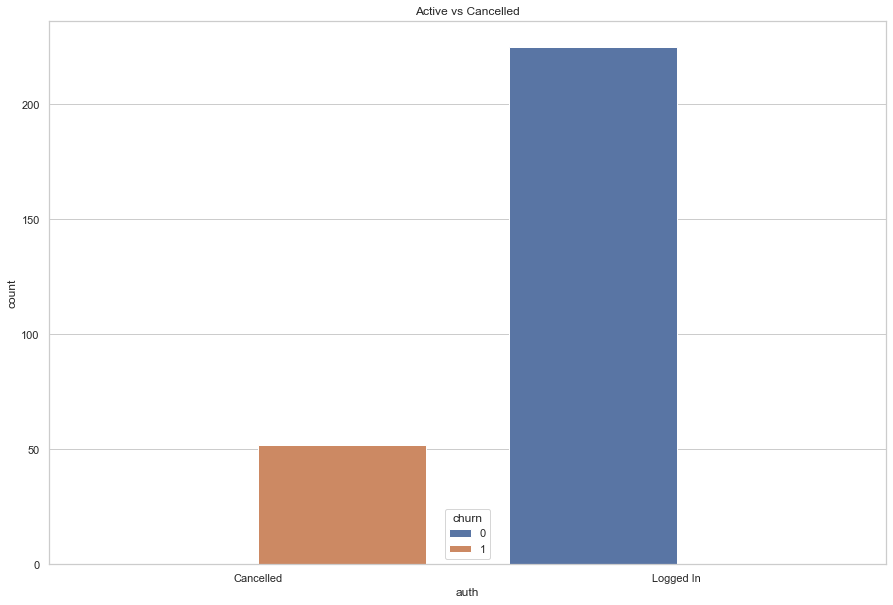

In [50]:
frequency_plot(sdf, 'auth','Active vs Cancelled')

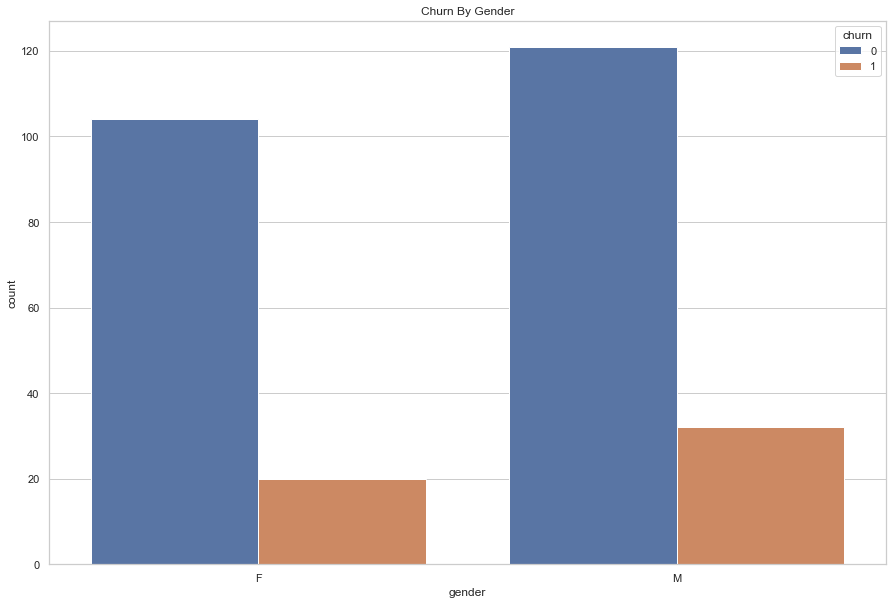

In [51]:
frequency_plot(sdf, 'gender','Churn By Gender')

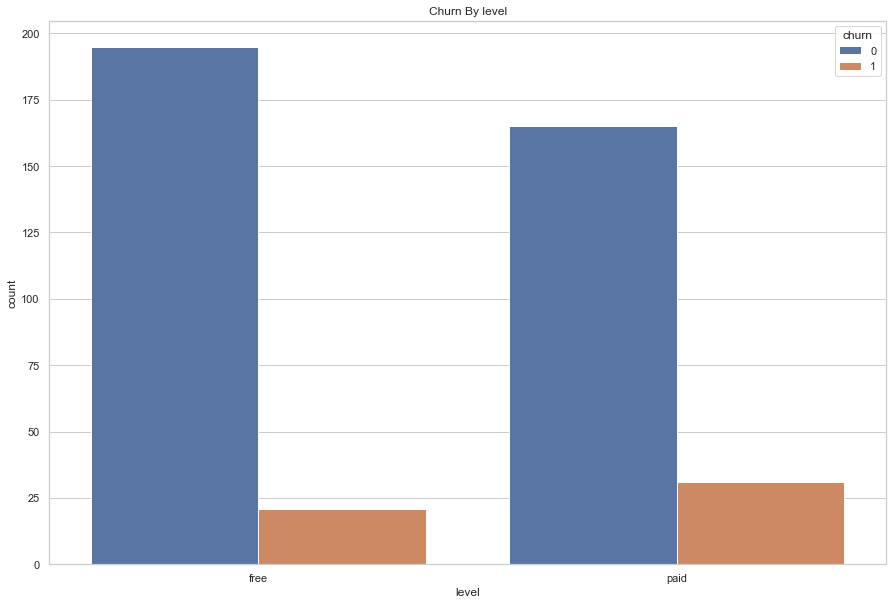

In [53]:
frequency_plot(sdf, 'level','Churn By level')

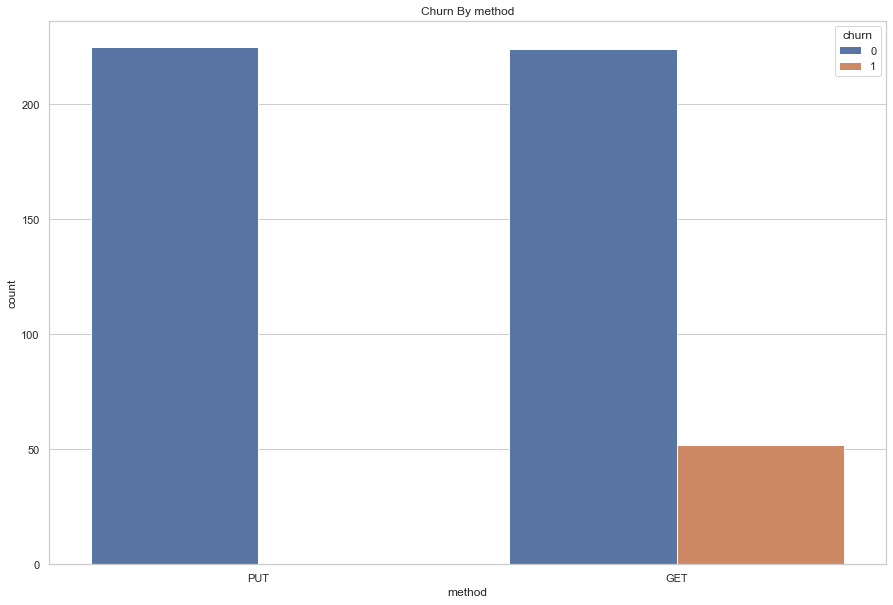

In [54]:
frequency_plot(sdf, 'method','Churn By method')

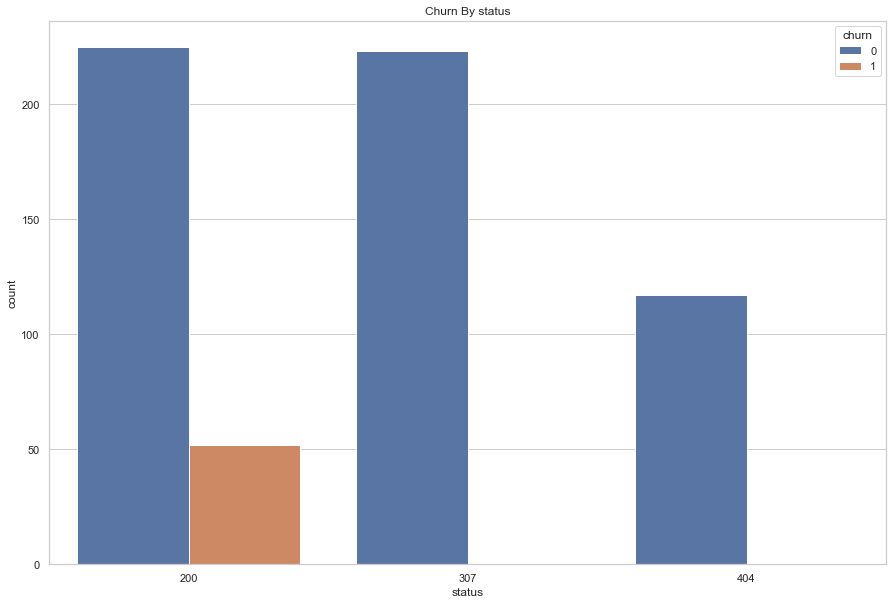

In [60]:
frequency_plot(sdf, 'status','Churn By status')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [127]:
churn_data = sdf.select('userId', col('churn')).dropDuplicates().groupby('userId').agg({"churn": "max"}).withColumnRenamed("max(churn)", "label")
churn_data.show(n=5)


+------+-----+
|userId|label|
+------+-----+
|200002|    0|
|100010|    0|
|   125|    1|
|     7|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [24]:
gender = sdf.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
gender.show(n=5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



In [25]:
friend_count = sdf.where(sdf.page == 'Add Friend').groupby('userId').agg(count('userId').alias('friend_count'))
friend_count.show(n=5)

+------+------------+
|userId|friend_count|
+------+------------+
|100010|           4|
|200002|           4|
|    51|          28|
|   124|          74|
|     7|           1|
+------+------------+
only showing top 5 rows



In [26]:
playlist_count = sdf.where(sdf.page == 'Add to Playlist').groupby('userId').agg(count('userId').alias('playlist_count'))
playlist_count.show(n=5)

+------+--------------+
|userId|playlist_count|
+------+--------------+
|100010|             7|
|200002|             8|
|    51|            52|
|   124|           118|
|     7|             5|
+------+--------------+
only showing top 5 rows



In [12]:
song_count = sdf.where(sdf.page == 'NextSong').groupby('userId').agg(count('userId').alias('song_count'))
song_count.show(n=5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



In [19]:
thumbsup_count = sdf.where(sdf.page=='Thumbs Up').groupby("userId").agg(count('page').alias('thumbsup_count'))
thumbsup_count.show(n=5)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows



In [20]:
thumbsdown_count = sdf.where(sdf.page=='Thumbs Down').groupby("userId").agg(count('page').alias('thumbsdown_count'))
thumbsdown_count.show(n=5)

+------+----------------+
|userId|thumbsdown_count|
+------+----------------+
|100010|               5|
|200002|               6|
|    51|              21|
|   124|              41|
|     7|               1|
+------+----------------+
only showing top 5 rows



In [76]:
avg_daily_sessions = sdf.select('userId', 'date', 'sessionId').dropDuplicates().groupby('userId', 'date').agg(count('sessionId').alias('count')).groupby('userId').agg(round(avg('count')).alias('avg_daily_sessions'))

avg_daily_sessions.show(n=5) 

+------+------------------+
|userId|avg_daily_sessions|
+------+------------------+
|200002|               1.0|
|100010|               1.0|
|   125|               1.0|
|    51|               1.0|
|   124|               1.0|
+------+------------------+
only showing top 5 rows



In [4]:

def features(sdf):

    churn_data = sdf.select('userId', col('churn')).dropDuplicates().groupby('userId').agg({"churn": "max"}).withColumnRenamed("max(churn)", "label")

    gender = sdf.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

    friend_count = sdf.where(sdf.page == 'Add Friend').groupby('userId').agg(count('userId').alias('friend_count'))

    playlist_count = sdf.where(sdf.page == 'Add to Playlist').groupby('userId').agg(count('userId').alias('playlist_count'))

    song_count = sdf.where(sdf.page == 'NextSong').groupby('userId').agg(count('userId').alias('song_count'))

    thumbsup_count = sdf.where(sdf.page=='Thumbs Up').groupby("userId").agg(count('page').alias('thumbsup_count'))

    thumbsdown_count = sdf.where(sdf.page=='Thumbs Down').groupby("userId").agg(count('page').alias('thumbsdown_count'))

    avg_daily_sessions = sdf.select('userId', 'date', 'sessionId').dropDuplicates().groupby('userId', 'date').agg(count('sessionId').alias('count'))\
        .groupby('userId').agg(round(avg('count')).alias('avg_daily_sessions'))
    
    features = churn_data.join(gender, "userId").join(friend_count, "userId").join(playlist_count, "userId").join(song_count, "userId").join(thumbsup_count, "userId")\
        .join(thumbsdown_count, "userId").join(avg_daily_sessions, "userId")

    return features

features_df = features(sdf)

In [130]:
data = features_df.toPandas()
data.to_csv("output_File.csv")

In [5]:
features_df.show(n=5) # 51

+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+
|userId|label|gender|friend_count|playlist_count|song_count|thumbsup_count|thumbsdown_count|avg_daily_sessions|
+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+
|100010|    0|     1|           4|             7|       275|            17|               5|               1.0|
|200002|    0|     0|           4|             8|       387|            21|               6|               1.0|
|   124|    0|     1|          74|           118|      4079|           171|              41|               1.0|
|    51|    1|     0|          28|            52|      2111|           100|              21|               1.0|
|     7|    0|     0|           1|             5|       150|             7|               1|               1.0|
+------+-----+------+------------+--------------+----------+--------------+----------------+------------

In [13]:
sdf.show(n=5)

+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+--------------------+------+-----+------+-------------------+
|          artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           userAgent|userId|churn| state|          date_time|
+----------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+--------------------+------+-----+------+-------------------+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|Mozilla/5.0 (Wind...|    30|    0|    CA|2018-09-30 20:01:57|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|   PUT|NextSong|1538331630000|        8|              Canada|   200|"Mozilla/5.0 (Win...|     9|    0| MA-NH|2018-09-30 20:03:00|
|    Adam Lambert|Logged 

In [9]:
sdf.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- date_time: timestamp (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [77]:
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.classification import GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [11]:

cols = ["gender", "friend_count", "playlist_count", \
          'playlist_count','song_count','thumbsup_count','thumbsdown_count','avg_daily_sessions']
assembler = VectorAssembler(inputCols=cols, outputCol="features")
data = assembler.transform(features_df)

In [12]:
data.show()

+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+--------------------+
|userId|label|gender|friend_count|playlist_count|song_count|thumbsup_count|thumbsdown_count|avg_daily_sessions|            features|
+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+--------------------+
|100010|    0|     1|           4|             7|       275|            17|               5|               1.0|[1.0,4.0,7.0,7.0,...|
|200002|    0|     0|           4|             8|       387|            21|               6|               1.0|[0.0,4.0,8.0,8.0,...|
|   124|    0|     1|          74|           118|      4079|           171|              41|               1.0|[1.0,74.0,118.0,1...|
|    51|    1|     0|          28|            52|      2111|           100|              21|               1.0|[0.0,28.0,52.0,52...|
|     7|    0|     0|           1|             5|       150|         

In [17]:
scaler = StandardScaler(inputCol = 'features', outputCol = "final_features", withStd = True)
scaler_model = scaler.fit(data)
scale_data = scaler_model.transform(data)

In [19]:
final_data = scale_data.select(scale_data.label, scale_data.final_features.alias("features"))

In [21]:
final_data.show(n=5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[1.99749598442950...|
|    0|[0.0,0.1923880199...|
|    0|[1.99749598442950...|
|    1|[0.0,1.3467161393...|
|    0|[0.0,0.0480970049...|
+-----+--------------------+
only showing top 5 rows



In [23]:
train, test = data.randomSplit([0.80, 0.20], seed = 143)

In [33]:
base_GBT_model = GBTClassifier()
base_GBT_model_fit = base_GBT_model.fit(train)
base_GBT_model_results = base_GBT_model_fit.transform(test)
base_GBT_evaluation = MulticlassClassificationEvaluator(predictionCol="prediction")
base_GBT_evaluator_auc = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')


print("Metrics for Logistic Regression model")
base_GBT_model_accuracy = str(base_GBT_evaluation.evaluate(base_GBT_model_results, {base_GBT_evaluation.metricName: "accuracy"}))
base_GBT_model_f1_score = str(base_GBT_evaluation.evaluate(base_GBT_model_results, {base_GBT_evaluation.metricName: "f1"}))
base_GBT_model_auc = str(base_GBT_evaluator_auc.evaluate(base_GBT_model_results, {base_GBT_evaluator_auc.metricName: "areaUnderROC"}))
print("Accuracy: " + base_GBT_model_accuracy)
print("F-1 Score: " + base_GBT_model_f1_score)
print("Area under ROC Curve: " + base_GBT_model_auc)


Metrics for Logistic Regression model
Accuracy: 0.6923076923076923
F-1 Score: 0.6780397022332507
Area under ROC Curve: 0.5277777777777778


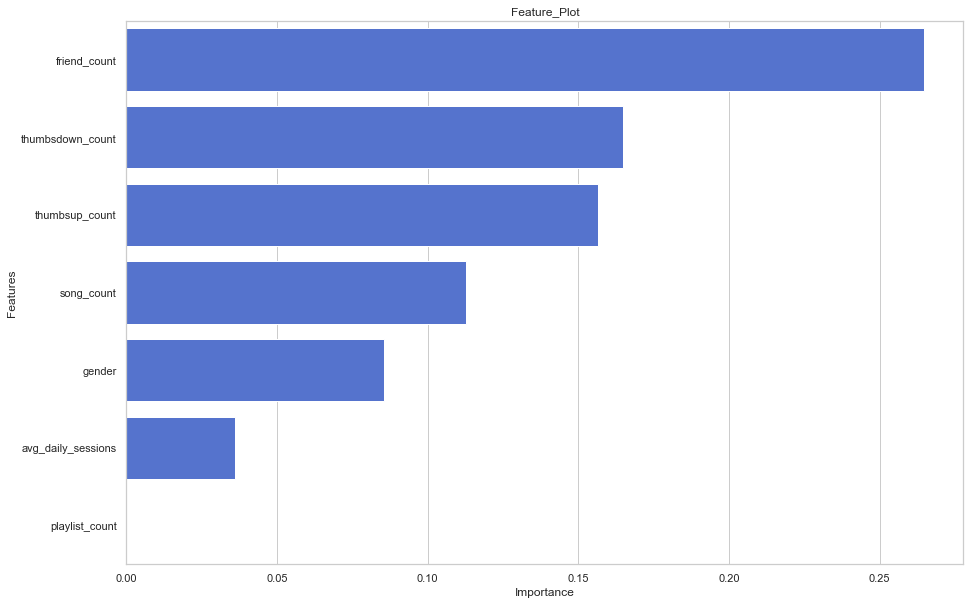

In [75]:
values = list(base_GBT_model_fit.featureImportances)

my_dict = dict(zip(cols, values)).items()

feature_df = pd.DataFrame(list(my_dict),columns=['Features', 'Importance']).sort_values('Importance', ascending=False)

sns.barplot(data=feature_df, y='Features',x='Importance',color="royalblue").set_title('Feature_Plot');
 

In [32]:
base_svm_model = LinearSVC()
base_svm_model_fit = base_svm_model.fit(train)
base_svm_model_results = base_svm_model_fit.transform(test)
base_svm_evaluation = MulticlassClassificationEvaluator(predictionCol="prediction")
base_svm_evaluator_auc = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')

print("Metrics for Logistic Regression model")
base_svm_model_accuracy = str(base_svm_evaluation.evaluate(base_svm_model_results, {base_svm_evaluation.metricName: "accuracy"}))
base_svm_model_f1_score = str(base_svm_evaluation.evaluate(base_svm_model_results, {base_svm_evaluation.metricName: "f1"}))
base_svm_model_auc = str(base_svm_evaluator_auc.evaluate(base_svm_model_results, {base_svm_evaluator_auc.metricName: "areaUnderROC"}))
print("Accuracy: " + base_svm_model_accuracy)
print("F-1 Score: " + base_svm_model_f1_score)
print("Area under ROC Curve: " + base_svm_model_auc)

Metrics for Logistic Regression model
Accuracy: 0.7692307692307693
F-1 Score: 0.6688963210702342
Area under ROC Curve: 0.5


In [79]:
#best model
# https://forums.databricks.com/questions/12097/pyspark-how-to-get-best-params-in-grid-search.html
# https://www.sparkitecture.io/machine-learning/classification/gradient-boosted-trees

best_GBT_model = GBTClassifier()

gbparamGrid = (ParamGridBuilder()
             .addGrid(best_GBT_model.maxDepth, [2, 5, 10])
             .addGrid(best_GBT_model.maxBins, [10, 20, 40])
             .addGrid(best_GBT_model.maxIter, [5, 10, 20])
             .build())

gbcv = CrossValidator(estimator = best_GBT_model,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = MulticlassClassificationEvaluator(),
                      numFolds = 2)
cv = gbcv.fit(train)


In [82]:
cv.avgMetrics

[0.6485230769557375,
 0.6485230769557375,
 0.6610820977921767,
 0.6581020130946937,
 0.6533402753673494,
 0.6436451611946231,
 0.6552384784190786,
 0.6552384784190786,
 0.6464125153777988,
 0.6666291369029389,
 0.6592967706121711,
 0.6482451729777335,
 0.642759730961991,
 0.6534901388517511,
 0.6495874582043856,
 0.6251295987577721,
 0.6344083247760406,
 0.6339924848667473,
 0.666275894264855,
 0.6621886009986546,
 0.6498810950630978,
 0.6147627763661991,
 0.6147627763661991,
 0.6147627763661991,
 0.6148478835834383,
 0.6148478835834383,
 0.6148478835834383]

In [81]:
# https://forums.databricks.com/questions/12097/pyspark-how-to-get-best-params-in-grid-search.html
bestPipeline = cv.bestModel
print(bestPipeline)

GBTClassificationModel: uid = GBTClassifier_7a930f3921c3, numTrees=5, numClasses=2, numFeatures=8


In [83]:
cv.bestModel.extractParamMap()

{Param(parent='GBTClassifier_7a930f3921c3', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_7a930f3921c3', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_7a930f3921c3', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

In [85]:
cv.bestModel.save('best_GBTClassifier_model')

In [7]:
features_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- friend_count: long (nullable = false)
 |-- playlist_count: long (nullable = false)
 |-- song_count: long (nullable = false)
 |-- thumbsup_count: long (nullable = false)
 |-- thumbsdown_count: long (nullable = false)
 |-- avg_daily_sessions: double (nullable = true)



In [6]:
features_df.show(n=5)

+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+
|userId|label|gender|friend_count|playlist_count|song_count|thumbsup_count|thumbsdown_count|avg_daily_sessions|
+------+-----+------+------------+--------------+----------+--------------+----------------+------------------+
|100010|    0|     1|           4|             7|       275|            17|               5|               1.0|
|200002|    0|     0|           4|             8|       387|            21|               6|               1.0|
|   124|    0|     1|          74|           118|      4079|           171|              41|               1.0|
|    51|    1|     0|          28|            52|      2111|           100|              21|               1.0|
|     7|    0|     0|           1|             5|       150|             7|               1|               1.0|
+------+-----+------+------------+--------------+----------+--------------+----------------+------------

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.